# Convolutional Residual Autoencoder for $\phi_{CR}, R_0, w_0, Z$  of a CR image
---
CR-CRAE = CR2AE
---

---

In [1]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as display_IPython
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import h5py

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the functions and routines for the DL
### Define the model and its constructor

In [2]:
class CR2Autoencoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1,
                 latent_representation_dims=10,
                 out_fc_3 = 10
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(CR2Autoencoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        self.in_fc = feats_4*int(conv4_feat_size/av_pool2_div+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=latent_representation_dims, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)
        
        self.batchNorm22 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm44 = nn.BatchNorm2d(num_features=feats_4)
        
        self.fc3 = nn.Linear(in_features=latent_representation_dims, out_features=out_fc_3, bias=True)
        self.fc4 = nn.Linear(in_features=out_fc_3, out_features=4, bias=True)
        
        self.fc5 = nn.Linear(in_features=latent_representation_dims, out_features=self.in_fc, bias=True)
        self.deConv5 = torch.nn.ConvTranspose2d(in_channels=2*feats_4, out_channels=feats_4, 
                                                kernel_size = int(conv4_feat_size*(1-1/av_pool2_div)) +1)
        self.deConv6 = torch.nn.ConvTranspose2d(in_channels=2*feats_4, out_channels=feats_2, 
                                                kernel_size = int(prop2*(2*X+1)/5-conv4_feat_size+1 ))
        self.deConv7 = torch.nn.ConvTranspose2d(in_channels=2*feats_2, out_channels=feats_1, 
                                                kernel_size = int((2*X+1)/5*(prop1-prop2)+1))
        self.deConv8 = torch.nn.ConvTranspose2d(in_channels=2*feats_1, out_channels=1, 
                                                kernel_size = int((2*X+1)/5*(5-prop1)+1))
        

    def encoder(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        
        encoded4 = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        encoded3 = self.batchNorm2( self.relu( self.conv2(self.dropout1(encoded4)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(encoded3)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        encoded2 = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        encoded1 = self.relu( self.avPool2(encoded2) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        
        x = encoded1.view(encoded1.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, latent_representation_dims]
        
        return x, encoded1, encoded2, encoded3, encoded4
    
    
    
    def image_decoder(self, latent_representation, encoded1, encoded2, encoded3, encoded4 ):        
        # latent_representation is [batch_size, latent_representation_dims]
        # first a fc to turn it back to the shape tkhe last convolution of the encoder left
        x = self.relu(self.fc5(latent_representation)) # [batch_size, feats_4*int(conv4_feat_size/av_pool2_div+1)**2]
        
        x = x.view( encoded1.shape ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        
        x = torch.hstack( (x, encoded1)) # [batch_size, 2*feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        
        x = self.batchNorm44(self.dropout2(self.deConv5(x))) # [batch_size, feats4, conv4_feat_size]

        x = torch.hstack( (x, encoded2) ) # [batch_size, 2*feats4, conv4_feat_size]
        
        x = self.batchNorm22(self.relu(self.dropout2(self.deConv6(x)))) # [batch_size, feats2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        
        x = torch.hstack( (x, encoded3) ) # [batch_size, feats2*2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        
        x = self.relu(self.dropout1(self.deConv7(x))) # [batch_size, feats1, prop1*(2X+1)/5, prop1*(2X+1)/5]

        x = torch.hstack( (x, encoded4) ) # [batch_size, feats1*2, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        return self.deConv8(x).squeeze(1) # [batch_size, 2X+1, 2X+1]
      
    def label_decoder(self, latent_representation):
        return self.fc4(self.relu(self.fc3(latent_representation)))

    
    def forward(self, x):
        latent, encoded1, encoded2, encoded3, encoded4 = self.encoder(x)
        predicted_labels = self.label_decoder(latent)
        reconstructed_images = self.image_decoder(latent, encoded1, encoded2, encoded3, encoded4)
        return predicted_labels, reconstructed_images
    


In [4]:
# subroutine to count number of parameters in the model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

### The routines to validate and train

In [5]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate_epoch(label_criterion, reconstruction_criterion, model, sampler, dataset): #show_confusion_matrix = False):

    val_loss = 0
    max_abs_im_error = torch.Tensor([0]).to(device)
    mean_abs_im_error = 0
    max_abs_lb_error = torch.Tensor([0]).to(device)
    mean_abs_lb_error = 0
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)

    model.eval()

    for batch_id, sample_batch_idxs in enumerate(sampler):
        
        data, target_labels, target_images = dataset[sample_batch_idxs] # each data, target is a whole batch of samples
        # data is [batch_size, 2X+1, 2X+1], target_labels is [batch_size, 4], target_images is [batch_size, 2X+1, 2X+1]
        
        predicted_labels, predicted_images = model(data)
        target_images = target_images.view(predicted_images.shape) # to add the 1 dimension of the single channel
        loss = label_criterion(predicted_images, target_images.float())+reconstruction_criterion(
                                                                predicted_labels, target_labels)
        val_loss += loss.item()                                                              
        max_abs_im_error = torch.maximum(torch.max(torch.abs(predicted_images-target_images), 0).values, max_abs_im_error)
        mean_abs_im_error += torch.sum(torch.abs(predicted_images-target_images), 0)
        max_abs_lb_error = torch.maximum(torch.max(torch.abs(predicted_labels-target_labels), 0).values, max_abs_lb_error)
        mean_abs_lb_error += torch.sum(torch.abs(predicted_labels-target_labels), 0)
        

    val_loss /= len(dataset)
    mean_abs_im_error /= len(dataset)
    mean_abs_lb_error /= len(dataset)
    #accuracy = 100. * correct / len(loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}\n\n Average Abs Image Error: {np.array(mean_abs_im_error.cpu()/len(dataset))}, Maximum Abs Image Error: {np.array(max_abs_im_error.cpu())} \n\n')
    print(f'Average Abs Image Error: {np.array(mean_abs_lb_error.cpu()/len(dataset))}, Maximum Abs Image Error: {np.array(max_abs_lb_error.cpu())}')
    #if show_confusion_matrix:
    #    visualize_confusion_matrix(preds.to(torch.device('cpu')), targets.to(torch.device('cpu')))

    return val_loss


def train_epoch(epoch, label_criterion, reconstruction_criterion, model, optimizer, sampler, dataset, 
                print_loss_every_batches=20, optimizer_step_every_batches=3, label_cost_weight=1):
    
    total_loss = 0.0

    model.train()
    
    for batch_id, sample_batch_idxs in enumerate(sampler):
        
        data,  target_labels, target_images = dataset[sample_batch_idxs]  # each data, target is a whole batch of samples
        # data is [batch_size, 2X+1, 2X+1], target_labels is [batch_size, 4], target_images is [batch_size, 2X+1, 2X+1]

        # data, target = data.to(device), target.to(device) DATA AND TARGET ARE ALREADY IN GPU!

        predicted_labels, predicted_images = model(data)
        loss = label_cost_weight*label_criterion(predicted_labels, target_labels)+reconstruction_criterion(predicted_images, target_images.float())
        loss.backward()
        if batch_id % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        
        # print loss every N batches
        if batch_id % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_id * len(data), len(dataset),
                print_loss_every_batches * batch_id / len(dataset), loss.item()))


        total_loss += loss.item()  #.item() is very important here
        # Why?-> In order to avoid having total_loss as a tensor in the gpu

    return total_loss / len(dataset)

### The full training loop

In [6]:
def full_training_loop(model, label_criterion, reconstruction_criterion, optimizer, sampler, dataset, epochs=10,
                       print_loss_every_batches=20, validate_every_epochs=20, optimizer_step_every_batches=3,
                      label_cost_weight=1):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, label_criterion, reconstruction_criterion, model, optimizer,
                                 sampler, dataset, print_loss_every_batches=print_loss_every_batches,
                                 optimizer_step_every_batches=optimizer_step_every_batches, label_cost_weight=label_cost_weight)
        display_IPython.clear_output(wait=True)
        #if epoch%validate_every_epochs==0:
        #    val_loss = validate_epoch(label_criterion, reconstruction_criterion, model, sampler, dataset)
        losses["train"].append(train_loss)
        #losses["val"].append(val_loss)
        

        plt.plot(losses["train"], label="log training loss")
        #plt.plot(losses["val"], label="log validation loss")
        plt.yscale('log')
        plt.legend()
        plt.pause(0.001)
        plt.show()   
    return losses

### The loss function

In [7]:
def CR_loss(estimation, target, extra_power_to_angles, loss_calculator):
    # we wish to have maximum accuracy with the angles
    return loss_calculator(estimation, target) + extra_power_to_angles * loss_calculator(estimation[:,-1], target[:,-1])

### The Dataset class and Data Sampler

In [8]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
#device="cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

'''
La idea es que cada 5 epochs, se cambie el dataset efectivo, que sera un subset de los R0,w0,Z posibles
multiplicado por el batch size (phiCR posibles). En cada batch, las imagenes enviadas seran todas
de un mismo D matrix (R0,w0,Z) con diferentes angulos elegidos aleatoriamente con una uniforme
'''
class R0_w0_Z_Sampler(Sampler):
    def __init__(self, R0_weights, w0_weights, Z_weights, num_batches_per_epoch):
        self.num_batches = num_batches_per_epoch
        self.R0_weights = R0_weights
        self.w0_weights = w0_weights
        self.Z_weights = Z_weights

    def __iter__(self):
        return iter(torch.stack((
            torch.multinomial(self.R0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.w0_weights, self.num_batches, replacement=True),
            torch.multinomial(self.Z_weights, self.num_batches, replacement=True)),
            dim=1).tolist())

    def __len__(self):
        return self.num_samples


class CR_Dataset(Dataset):
    def __init__(self, D_matrix_file_path, ID_file_path, device, X=605, generate_images_w_depth=8, random_seed=666, 
                batch_size=10, num_batches_per_epoch=100, apply_noise=True,
                all_stregths_random_per_epoch=False,
                max_poisson_strength=0.5, max_blob_strength=0.5, max_angular_modulation_strength=0.5,
                poisson_strength=0.3, blob_strength=0.1, angular_modulation_strength=0.25,
                min_modulation_frec=2*np.pi/6, max_modulation_frec=2*np.pi/2,
                max_blobs=1, min_blob_sigma=100, max_blob_sigma=130
                ):
        # If all_strengths_random_per_ecpoh, then arguments about the maximum will be valid while not the strength arguments
        # If false, then the arguments about the particular stregths will be the global stregths
        np.random.seed(random_seed) 
        torch.manual_seed(random_seed)
        self.D_matrix_file_path=D_matrix_file_path
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(ID_file_path)))       
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch
        self.epoch_size = batch_size*num_batches_per_epoch
        self.device = device
        self.im_type = torch.uint16 if generate_images_w_depth==16 else torch.uint8
        self.max_intensity = 65535 if generate_images_w_depth==16 else 254
        self.X=X
        self.apply_noise=apply_noise
        self.poisson_strength=poisson_strength
        self.blob_strength=blob_strength
        self.angular_modulation_strength=angular_modulation_strength
        self.min_modulation_frec=min_modulation_frec
        self.max_modulation_frec=max_modulation_frec
        self.max_blobs=max_blobs
        self.min_blob_sigma=min_blob_sigma
        self.max_blob_sigma=max_blob_sigma
        self.all_stregths_random_per_epoch=all_stregths_random_per_epoch
        self.max_poisson_strength=max_poisson_strength
        self.max_blob_strength=max_blob_strength
        self.max_angular_modulation_strength=max_angular_modulation_strength
        
    #def update_dataset o set_epoch_number y que aqui se genere directamente el dataset entero para las epochs que vienen
    # lo que permitiria es que cada X epochs, se ahorrase el tener que re-generar todas las imagenes
    # Pero claro, la pregunta es, la RAM aguantaria?
    # Si haces con update_dataset, entonces no haria falta hacer un sampler custom, con el normal ya bastaria
    
    # Bueno, por ahora, vamos a hacer que en cada minibatch, se haga todo el puroceso. La cosa es que asi se 
    # puede aprovechar el multiprocessing innato, si no habria que hacer el multiprocessing dentroe del update_dataset
    # o simplemente prescindir de hacerlo supongo.
    
    def __del__(self):
        if hasattr(self, 'h5f_D_matrices'):
            self.h5f_D_matrices.close()
        
    def __len__(self):
        return self.epoch_size
    
    def open_hdf5(self):
        self.h5f_D_matrices = h5py.File( self.D_matrix_file_path, 'r')
        #self.dataset = self.img_hdf5['dataset'] # if you want dataset.
        

    def compute_intensity_gravity_centers(self, images):
        """
            Expects input image to be an array of dimensions [N_imgs, h, w].
            It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to array indices

        """
        # image wise total intensity and marginalized inensities for weighted sum
        intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
        intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
        total_intensity = intensity_in_h.sum(dim=1) # [N_images]

        # Compute mass center for intensity
        # [N_images, 2] (h_center,w_center)
        return torch.nan_to_num( torch.stack(
            (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                        dtype=torch.float32, device=self.device))/total_intensity,
             torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                        dtype=torch.float32, device=self.device))/total_intensity),
            dim=1
            ), nan=0.0, posinf=None, neginf=None)

    def compute_raw_to_centered_iX(self, images):

        g_raw = self.compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*self.X+1, 2*self.X+1),  dtype = images.dtype, 
                                      device=self.device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-self.X
        unclipped_upper = g_index_raw+self.X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(self.device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(self.device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images
    
    def apply_random_camera_noises(self, images):
        # Poisson noise
        # the images are expected to already be normalized and in the integer range of the camera
        return torch.clamp((1-self.poisson_strength)*images+self.poisson_strength*torch.poisson(images), max=self.max_intensity) 
                                    # rates are the expected intensities of the imaging time

    def _gaussian_2D_pdfs(self, x_ys, mus, sigmas, strengths):
        '''
        x_ys : [batch_size, blob_num, 2 (h,w), 2X+1, 2X+1]
        mus : [batch_size, blob_num, 2 (h,w), 1, 1]
        sigmas : [batch_size, blob_num, 2(h,w), 1, 1]
        strengths : [batch_size, blob_num, 1, 1]
        ------
        out : [batch_size, 2X+1, 2X+1]
        '''
        gaussians = torch.sum((strengths/(2*np.pi)/sigmas[:,:,0]/sigmas[:,:,1])*torch.exp(
                -(x_ys[:,:,0,:,:]-mus[:,:,0])**2/(2*sigmas[:,:,0]**2))*torch.exp(
                -(x_ys[:,:,1,:,:]-mus[:,:,1])**2/(2*sigmas[:,:,1]**2)), dim=1) # since strength is normalized, the whole mixture is normalized as well
        return gaussians/gaussians.amax(dim=(1,2)).unsqueeze(1).unsqueeze(2)

    def apply_random_pre_camera_noises(self, images):
        # note that the input images are expected to still be centered in the gravicenter and have no normalization

        # Gaussian Blobs - subtract gaussian blobs of different depths to the intensity pattern
        # First randomly sample the centers of the blobs and their standard deviations for each image
        # we will sample the means with probabilities proportional to the CR ring intensity pattern
        blob_num = np.random.randint(0, self.max_blobs+1, size=1)[0]
        if blob_num!=0:
            mu_s = torch.stack(
                (torch.multinomial(images.sum(dim=2),
                        num_samples=blob_num, 
                        replacement=False), 
                 torch.multinomial(images.sum(dim=1),
                        num_samples=blob_num, 
                        replacement=False) ),
                 dim=2
                ).to(self.device) #[batch_size, blob_num, 2(h,w)] mu-s are in pixel units and coordinates

            sigma_s = torch.from_numpy(np.random.randint(self.min_blob_sigma, self.max_blob_sigma, 
                        size=(images.shape[0], blob_num, 2))).to(self.device) #[batch_size, blob_num, 2(h,w)]
            strengths = torch.rand(size=(images.shape[0], blob_num)).to(self.device) #[batch_size, blob_num]
            strengths = strengths/strengths.sum(dim=1).unsqueeze(1) # normalized strengths between blobs

            w = torch.arange(images.shape[1]).repeat((images.shape[1],1)).to(self.device)
            h = w.transpose(0,1).to(self.device)
            h_w = torch.stack((h,w), dim=0).to(self.device)
            images = images*(1-self.blob_strength*self._gaussian_2D_pdfs( h_w.view((1,1)+h_w.shape), 
                mu_s.view(mu_s.shape+(1,1)), sigma_s.view(sigma_s.shape+(1,1)), strengths.view(strengths.shape+(1,1)) )
                     )           #[batch_size, 2X+1, 2X+1]        
        # Poisson noise - makes the intesity be a poissonian generated value instead of the expected values
        #images = (1-poisson_strength)*images+poisson_strength*torch.poisson(images) # rates are the expected intensities of the imaging time
        # but must be an integer matrix!

        # Angular Modulation - apply a pseudo-random continous wave modulation to the ring angularly
        random_frecs = (self.min_modulation_frec + (self.max_modulation_frec-self.min_modulation_frec)*torch.rand(
                                size=(3,images.shape[0], 1,1))).to(self.device)
        strengths = torch.rand(size=(3, images.shape[0], 1,1)).to(self.device) #[3, batch_size, 1,1]
        strengths = strengths/strengths.sum(dim=0) # normalized strengths between sin and coss
        images = images*(
            1-self.angular_modulation_strength*(
                strengths[0]*torch.cos(random_frecs[0]*self.phis)+
                strengths[1]*torch.sin(random_frecs[1]*self.phis)+
                strengths[2]*torch.cos(random_frecs[2]*self.phis)
            )**2) #[batch_size, 2X+1, 2X+1]

        # Angular-Radial Modulation # sería coger phis y coger radios y con eso hacer uan funcion de ambas, de forma
        # que por ejemplo afecte de manera diferente al mismo angulo en cada ring el pre-pogendorf y el otro

        # Modos superiores
        # esto ya es un jaleo xD
        return images

    
    
    def __getitem__(self, R0_w0_Z_idxs):
        # In order to allow multiprocessing data loading, each worker needs to initialize 
        # the h5f loader, which must be done in the first iteration of getitem and not in the init
        # of the parent process
        if not hasattr(self, 'h5f_D_matrices'):
            self.open_hdf5()
            self.phis = torch.from_numpy(self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(self.device) #[1,Nx,Ny]

        D_mats = torch.from_numpy(self.h5f_D_matrices[
                f"R0_{self.R0s[R0_w0_Z_idxs[0]]}_w0_{self.w0s[R0_w0_Z_idxs[1]]}_Z_{self.Zs[R0_w0_Z_idxs[2]]}"][:]
                                 ).unsqueeze(1).to(self.device) #[2, 1, Nx, Ny]            
        
        phiCRs = torch.FloatTensor(self.batch_size, 1, 1).uniform_(0, 2*np.pi).to(self.device) #[batch_size, 1, 1]
        neat_images = D_mats[0]+D_mats[1]*torch.cos(phiCRs-self.phis) #[batch_size, Nx,Ny]
        
        if self.apply_noise:
            if self.all_stregths_random_per_epoch:
                self.poisson_strength = self.max_poisson_strength*np.random.rand()
                self.angular_modulation_strength = self.max_angular_modulation_strength*np.random.rand()
                self.blob_strength = self.max_blob_strength*np.random.rand()
            
            # Apply precamera noise to images (while still floats)
            spoiled_images = self.apply_random_pre_camera_noises(neat_images)
        
        # convert images to selected uint format
        spoiled_images = (self.max_intensity*(spoiled_images/spoiled_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1)))
        
        if self.apply_noise:
            # Apply camera noises (now that normalized and integers)
            spoiled_images = self.apply_random_camera_noises(spoiled_images)
        
        spoiled_images = spoiled_images.type(self.im_type)
    
        neat_images = (self.max_intensity*(neat_images/neat_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1))).type(self.im_type)
        
        
        # get iX images
        neat_images = self.compute_raw_to_centered_iX(neat_images) #[batch_size, 2X+1, 2X+1]
        spoiled_images = self.compute_raw_to_centered_iX(spoiled_images) #[batch_size, 2X+1, 2X+1]
        labels = torch.Tensor([[float(self.R0s[R0_w0_Z_idxs[0]]), float(self.w0s[R0_w0_Z_idxs[1]]), 
                               float(self.Zs[R0_w0_Z_idxs[2]])]]).to(self.device) #[1,4]
        labels = torch.hstack( ( labels.expand(self.batch_size, 3), phiCRs.squeeze(2) ) ) #[4, batch_size]
        del D_mats, phiCRs
        torch.cuda.empty_cache()
        return spoiled_images, labels, neat_images #[ batch_size, 2X+1, 2X+1] and [batch_size, 4]
        # The whole batch is already in the GPU, since to process it we wanted it to be there
    

cuda:0


---
# Initialize the dataset and sampler (choose the number of batches per epoch, and their length) and fix the artificial noise hyperparameters

Note that since in each epoch the dataset shown to the model will be random, we can use the same dataset as a validation set.

In [9]:
ID_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path= "/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/AutoEncoder/Dataset_R0_70_w0_70_Z_4.h5"

total_epochs = 20
number_of_batches_per_epoch = 21
batch_size = 5
validate_every_epochs=20
extra_power_to_angles=10
optimizer_step_every_batches = 3
label_cost_weight=100

assert(number_of_batches_per_epoch%optimizer_step_every_batches==0)


X=302
generate_images_w_depth=8
random_seed=666

apply_noise=True
all_stregths_random_per_epoch=True
max_poisson_strength=0.25
max_blob_strength=0.25
max_angular_modulation_strength=0.25
poisson_strength=0.4
blob_strength=0.2
angular_modulation_strength=0.2
min_modulation_frec=2*np.pi/6
max_modulation_frec=2*np.pi/2
max_blobs=2
min_blob_sigma=100
max_blob_sigma=130

In [10]:
def gaussian_pdf(x, mu, sigma, normalized_output=True):
    p_s = (1/np.sqrt(2*np.pi)/sigma)*torch.exp(-(x-mu)**2/(2*sigma**2))
    return p_s/p_s.sum() if normalized_output else p_s

phase_vigilant = pd.DataFrame.from_dict(json.load(open(ID_file_path)))
R0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['R0s'].drop_duplicates(), dtype=np.float64)),
                          mu=158, sigma=35)
w0_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['w0s'].drop_duplicates(), dtype=np.float64)),
                          mu=25, sigma=10)
Z_weights = gaussian_pdf(torch.from_numpy(np.array( phase_vigilant['Zs'].drop_duplicates(), dtype=np.float64)),
                          mu=0, sigma=0.5)

In [11]:
sampler = R0_w0_Z_Sampler( R0_weights, w0_weights, Z_weights,  num_batches_per_epoch=number_of_batches_per_epoch)
dataset = CR_Dataset(D_matrix_file_path=D_matrix_file_path,
            ID_file_path =ID_file_path, 
            device = device,
            X=X, generate_images_w_depth=generate_images_w_depth, random_seed=random_seed, 
            batch_size=batch_size, num_batches_per_epoch=number_of_batches_per_epoch,
            apply_noise=apply_noise, all_stregths_random_per_epoch=all_stregths_random_per_epoch,
            max_poisson_strength=max_poisson_strength, max_blob_strength=max_blob_strength,
            max_angular_modulation_strength=max_angular_modulation_strength,
            poisson_strength=poisson_strength, blob_strength=blob_strength, 
            angular_modulation_strength=angular_modulation_strength,
            min_modulation_frec=min_modulation_frec, max_modulation_frec=max_modulation_frec,
            max_blobs=max_blobs, min_blob_sigma=min_blob_sigma, max_blob_sigma=max_blob_sigma)

# Fix the Hyperparameters and Initialize the Model and the Optimizer

In [12]:
feats_1=15
feats_2=20
feats_3=20
feats_4=20
prop1=3
prop2=2
prop3=1
av_pool1_div=4
conv4_feat_size=15
av_pool2_div=10
out_fc_1=10
dropout_p1=0.2
dropout_p2=0.1
latent_representation_dims=10
out_fc_3 = 10

In [15]:
model = CR2Autoencoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2, 
                 latent_representation_dims=latent_representation_dims,
                 out_fc_3=out_fc_3 ) 

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/AutoEncoder/Model_opt_Adam_it_1_5sperbatchx21batchperepx6epochs_samples_feats_1=15_feats_2=20_feats_3=20_feats_4=20_prop1=3_prop2=2_prop3=1_av_pool1_div=4_conv4_feat_size=15_av_pool2_div=10_out_fc_1=10_dropout_p1=0.2_dropout_p2=0.1.pt")
#checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/AutoEncoder/Model_opt_Adam_8sperbatchx10batchperepx20epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")

# move model to gpu if available
model.to(device)

model.load_state_dict(checkpoint['model'])

# Initialize the weights of the model! Default initialization might already be fine!

# we can use a MSE loss for the regression task we have in hands
mse = nn.MSELoss()
param_criterion = lambda estimation, target: CR_loss(estimation, target, 
                                    extra_power_to_angles=extra_power_to_angles, loss_calculator=mse)
# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.99), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer.load_state_dict(checkpoint['optimizer'])

Number of parameters 63868250


# Run the Training

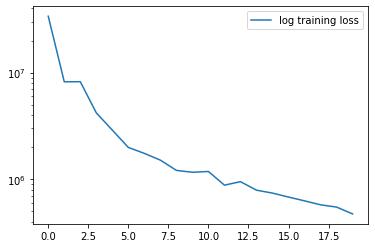

CPU times: user 3h 27min 46s, sys: 7.44 s, total: 3h 27min 54s
Wall time: 3h 30min 56s


In [16]:
%%time
losses = full_training_loop(model, param_criterion, mse, optimizer, sampler, dataset, 
                    epochs=total_epochs, print_loss_every_batches=1, validate_every_epochs=validate_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches,
                           label_cost_weight=label_cost_weight)
# Execute the training and validation

# Final Validation

In [ ]:
print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
validate_epoch(param_criterion, mse, model, sampler, dataset)
print("Test Set")
validate_epoch(param_criterion, mse, model, sampler, dataset)

# Save the resulting model weights

In [17]:
torch.save({'optimizer':optimizer.state_dict(),
            'model': model.state_dict(),
            }, f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/AutoEncoder/Model_opt_Adam_it_2_{batch_size}sperbatchx{number_of_batches_per_epoch}batchperepx{total_epochs}epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")

In [ ]:
raise ValueError

# Charge models and do inference

In [ ]:
checkpoint = torch.load(f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/OUTPUT/ML_Models.pt")

model = CR2Autoencoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2, 
                 latent_representation_dims=latent_representation_dims,
                 out_fc_3=out_fc_3 ) 

model.load_state_dict(checkpoint['model']).to(device)

# And we will use the same dataset to convert the experimental images to iX (not apply noise ofcourse)
dataset = CR_Dataset(D_matrix_file_path=D_matrix_file_path,
            ID_file_path =ID_file_path, 
            device = device,
            X=x, generate_images_w_depth=generate_images_w_depth, random_seed=random_seed 
            )

In [ ]:
# Create and display a FileChooser widget
from ipyfilechooser import FileChooser
path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter"
fc = FileChooser(path+'/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/')
display(fc)

### Choose a single experimental image to predict

In [ ]:
import cv2
image_full_path=fc.selected
#image_full_path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_positivo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)
if im is None:
    print(f" Unable to import image {image_full_path}")
    raise ValueError
# Center in gravicenter, generating iX
im = np.asarray((dataset.compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

### Plot its Profiles

In [ ]:
plot3d_resolution=0.7

%matplotlib notebook

prof_x=np.sum(im, axis=0)
prof_y=np.sum(im, axis=1)
fig = plt.figure(figsize=(2*4.5, 2*4.5))
axes=fig.subplots(2,2)
cm=axes[0, 0].imshow(im, cmap='viridis')
axes[0,0].grid(True)
axes[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
axes[0,1].set_ylim((0,len(prof_y)))
axes[0,1].invert_yaxis()
axes[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in y')
axes[1,0].set_xlim((0,len(prof_x)))
axes[1,0].invert_yaxis()
axes[0,0].set_xlabel("x (pixels)")
#axes[0,0].set_ylabel("y (pixels)")
axes[0,1].set_xlabel("Cummulative Intensity")
axes[0,1].set_ylabel("y (pixels)")
axes[1,0].set_ylabel("Cummulative Intensity")
axes[1,0].set_xlabel("x (pixels)")
axes[1,0].grid(True)
axes[0,1].grid(True)
axes[1,1].set_visible(False)
ax = fig.add_subplot(224, projection='3d')
X_g,Y = np.meshgrid(np.arange(len(prof_y)),np.arange(len(prof_x)))
fig.suptitle(f"Intesity Profiles for Image\n{image_full_path.split('/')[-1]}")
files_for_gif=[]
cbax=fig.add_axes([0.54,0.05,0.4,0.01])
fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')
theta=25
phi=30
ax.plot_surface(X_g, Y, im.T, rcount=int(len(prof_y)*plot3d_resolution), ccount=int(len(prof_x)*plot3d_resolution), cmap='viridis') # rstride=1, cstride=1, linewidth=0
#cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
#cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
#cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
ax.set_xlabel('Y')
#ax.set_xlim(-8, 8)
ax.set_ylabel('X')
#ax.set_ylim(-10, 8)
ax.set_zlabel('Intensity')
ax.set_zlim(-0.078*np.max(im), np.max(im))
ax.set_title("Image intensity 3D plot")
ax.view_init(10, theta)
#ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.3, 1.3, 1.3, 1]))
plt.show()

### Get NN predictions for $R_0, w_0, \phi_{CR}, Z$

In [18]:
for i in sampler:
    ims, labs, predicted_images = dataset[i]
    break
nims = np.asarray(ims.to('cpu'))
    

In [ ]:
model.state_dict()


In [ ]:
model.train()
predictied_labels, predicted_images = model(torch.zeros(im.shape).to(device).unsqueeze(0))
im = np.asarray(torch.zeros(im.shape))
predictied_labels

Predicted R_0 24.875656127929688, w_0 19.87520980834961, Z 0.07841522991657257, phiCR 3.0005970001220703


Predicted Polarization plane -relative to the image plane w axis- is 1.5002985000610352


<IPython.core.display.Javascript object>


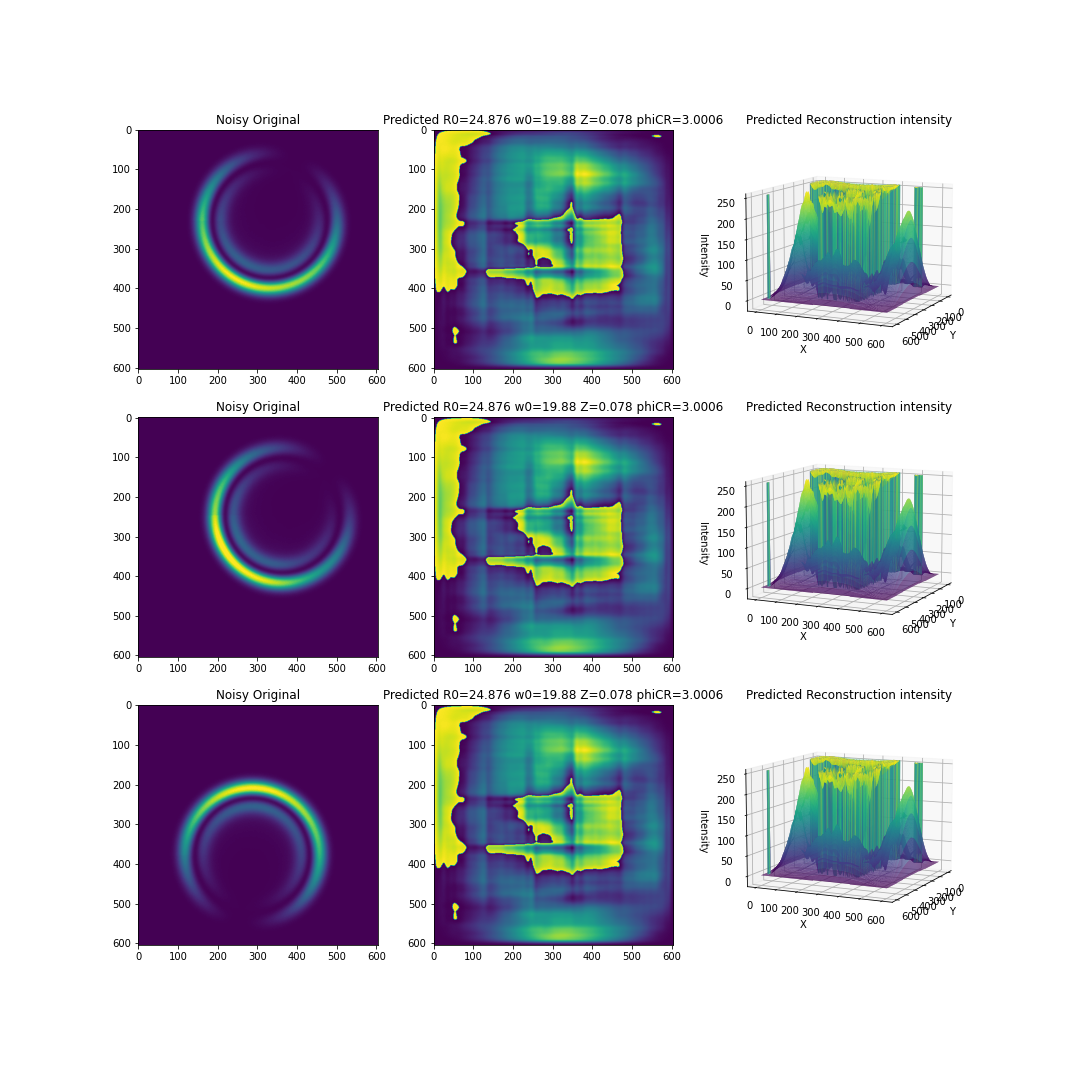

In [20]:
model.eval()
predictied_labels, predicted_images = model(ims)
# normalize the predicted images and turn them to uint8
predicted_images = (dataset.max_intensity*(predicted_images/predicted_images.amax(dim=(1,2), keepdim=True)[0].unsqueeze(1))).type(dataset.im_type)
predicted_images = np.asarray(predicted_images.to('cpu'))

print(f"Predicted R_0 {predictied_labels[0][0]}, w_0 {predictied_labels[0][1]}, Z {predictied_labels[0][2]}, phiCR {predictied_labels[0][3]}")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictied_labels[0][3]/2}")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

ims_to_show=3
fig, axes = plt.subplots(ims_to_show,3,figsize=(15,15))
for i in range(ims_to_show):
    if ims_to_show==1:
        axes=np.expand_dims(axes, 0)
    axes[i, 1].imshow(predicted_images[i].T)
    axes[i,1].set_title(f"Predicted R0={predictied_labels[i][0].item():.5} w0={predictied_labels[i][1].item():.4} Z={predictied_labels[i][2].item():.2} phiCR={predictied_labels[i][3].item():.6}")
    axes[i, 0].imshow(nims[i])
    axes[i,0].set_title(f"Noisy Original")
    axes[i, 2].set_visible(False)
    ax = fig.add_subplot(int(f"{ims_to_show}3{i*3+3}"), projection='3d')
    X_g,Y = np.meshgrid(np.arange(predicted_images.shape[1]),np.arange(predicted_images.shape[2]))
    theta=25
    phi=30
    plot3d_resolution = 0.4
    ax.plot_surface(X_g, Y, predicted_images[i].T, rcount=int(predicted_images.shape[1]*plot3d_resolution), ccount=int(predicted_images.shape[2]*plot3d_resolution), cmap='viridis') # rstride=1, cstride=1, linewidth=0
    #cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
    #cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
    #cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
    ax.set_xlabel('Y')
    #ax.set_xlim(-8, 8)
    ax.set_ylabel('X')
    #ax.set_ylim(-10, 8)
    ax.set_zlabel('Intensity')
    ax.set_zlim(-0.078*np.max(predicted_images[i]), np.max(predicted_images[i]))
    ax.set_title("Predicted Reconstruction intensity")
    ax.view_init(10, theta)
plt.show()

### Get the non-black-box algorithm estimate for $\phi_{CR}$

In [ ]:
import os
os.chdir(f"../../..")
import sys
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm, Gradient_Algorithm
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt

image=im.copy()
saturation=0.9
pol_or_CR="pol" 
deg_or_rad="deg" # for the final output
image_depth=8 # or 16 bit per pixel
image_shortest_side=540
randomization_seed=666
recenter_average_image=False


# 5. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Also a gradient algorithm
theta_min_Rot=-np.pi
theta_max_Rot=np.pi
rad_min_Grav=3
rad_max_Grav=image_shortest_side
theta_min_Mir=0
theta_max_Mir=np.pi
initial_guess_delta_rad=0.1
initial_guess_delta_pix=10
use_exact_gravicenter=True
precision_quadratic=1e-10
max_it_quadratic=100
cost_tolerance_quadratic=1e-14
precision_fibonacci=1e-10
max_points_fibonacci=100
cost_tolerance_fibonacci=1e-14


##################################################################
##################################################################
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255
np.random.seed(randomization_seed)
polCR=1 if pol_or_CR=='CR' else 0.5

# 6. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Results will be gathered in a table and outputed as an excel csv
# Mock Image Loader
# Computar el angulo de cada uno en un dataframe donde una de las entradas sea results y haya un result per fibo qfs y per rotation y mirror affine. Y luego procesar en un 7º paso estos angulos para obtener los angulos relativos etc y perhaps hacer tablucha con ground truth menos el resulting delta angle medido por el algoritmo
image_loader = Image_Manager(mode=X, interpolation_flag=None)
# Define the ROTATION ALGORITHM
rotation_algorithm = Rotation_Algorithm(image_loader,
    theta_min_Rot, theta_max_Rot, None,
    initial_guess_delta_rad, use_exact_gravicenter, initialize_it=False)

# Define the Affine Mirror algorithm
mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
    theta_min_Mir, theta_max_Mir, None,
    initial_guess_delta_rad, method="aff", left_vs_right=True, use_exact_gravicenter=use_exact_gravicenter, initialize_it=False)

# Define the Gradient algorithm
gradient_algorithm = Gradient_Algorithm(image_loader,
        rad_min_Grav, rad_max_Grav,
        initial_guess_delta_pix,
        use_exact_gravicenter)

# A dictionary to gather all the resulting angles for each image

individual_image_results = { 'polarization_method':[], 'optimization_1d':[], 'found_phiCR':[], 'predicted_opt_precision':[] }

def to_result_dict(result_dict, alg, alg_name, opt_name, im_names):
    for key, name in zip(alg.times.keys(), im_names):
        result_dict['polarization_method'].append(alg_name)
        result_dict['optimization_1d'].append(opt_name)
        result_dict['found_phiCR'].append(alg.angles[key])
        result_dict['predicted_opt_precision'].append(alg.precisions[key])
image_container=np.zeros( (1, 2*X+1, 2*X+1), dtype=np.float64)
image_names=[]
# charge the image
image_container[0]=image.astype(np.float64)
image_names.append(f"{fc.selected_filename}")

# charge the image loader:
image_loader.import_converted_images_as_array(image_container, image_names)
# Execute the Rotation and Mirror Algorithms:
# ROTATION ######
interpolation_flag=None
# the interpolation algorithm used in case we disbale its usage for the iX image obtention will be the Lanczos one
rotation_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Quadratic", image_names)
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Fibonacci", image_names)

# MIRROR #######
mirror_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Quadratic", image_names)
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Fibonacci", image_names)

# GRADIENT #######
optimal_masked_gravs={}
optimal_radii={}
grav=compute_intensity_gravity_center(image)

gradient_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Quadratic", image_names)
#optimal_masked_gravs['quad'] = gradient_algorithm.masked_gravs[f"Quadratic_Search_{fc.selected_filename}"]
#optimal_radii['quad'] = gradient_algorithm.optimals[f"Quadratic_Search_{fc.selected_filename}"]

gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Fibonacci", image_names)

#optimal_masked_gravs['fibo'] = gradient_algorithm.masked_gravs[f"Fibonacci_Search_{fc.selected_filename}"]
#optimal_radii['fibo'] = gradient_algorithm.optimals[f"Fibonacci_Search_{fc.selected_filename}"]

#masked_grav=(optimal_masked_gravs['quad']+optimal_masked_gravs['fibo'])/2.0
#optimal_radi = (optimal_radii['quad']+optimal_radii['fibo'])/2
#print(f"\n\nOptimal masked gravs: {optimal_masked_gravs}\nOptimal radii: {optimal_radii}\n\n\n")
print(pd.DataFrame.from_dict(individual_image_results))

# 7. PROCESS FINAL RESULTS ##########################################
def angle_to_pi_pi( angle): # convert any angle to range ()-pi,pi]
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle    

average_found_phiCR=np.mean([angle_to_pi_pi(phi) for i,phi in enumerate(individual_image_results['found_phiCR']) if individual_image_results['polarization_method'][i]!='Gradient'])
print("Average found phiCR:", average_found_phiCR)
#print(f"\n\nPredicted slope for main axis: by Gradient {(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])} and by the others averaged {np.tan(-average_found_phiCR)}")

In [3]:
'''
def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
    x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]) # [batch_size, 1, 2X+1, 2X+1]
    X=302
    feats_1=15
    feats_2=20
    feats_3=20
    feats_4=20
    prop1=3
    prop2=2
    prop3=1
    av_pool1_div=4
    conv4_feat_size=15
    av_pool2_div=10
    out_fc_1=10 
    print(x.shape, 2*X+1)

    x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
    print("conv1",x.shape, prop1*(2*X+1)/5)


    x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
    print("conv2",x.shape,  prop2*(2*X+1)/5)


    x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
    print("conv3",x.shape,  prop3*(2*X+1)/5)


    x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
    print("av_pool1",x.shape, int((prop3*(2*X+1)/5)/av_pool1_div))


    x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
    print("conv4+batchn",x.shape, conv4_feat_size)


    x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
    print("av_pool2",x.shape, int(conv4_feat_size/av_pool2_div)+1)


    x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
    print("view_change",x.shape, feats_4*int(conv4_feat_size/av_pool2_div+1)**2)


    x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 4]
    print(x.shape, 4)

        return x

def image_decoder(self, latent_representation, encoded1, encoded2, encoded3, encoded4 ):
        X=302
        feats_1=15
        feats_2=20
        feats_3=20
        feats_4=20
        prop1=3
        prop2=2
        prop3=1
        av_pool1_div=4
        conv4_feat_size=15
        av_pool2_div=10
        out_fc_1=10 
        latent_representation_dims=10
        out_fc_3 = 10
        
        # latent_representation is [batch_size, latent_representation_dims]
        # first a fc to turn it back to the shape tkhe last convolution of the encoder left
        x = self.relu(self.fc5(latent_representation)) # [batch_size, feats_4*int(conv4_feat_size/av_pool2_div+1)**2]
        print("fc5",x.shape, feats_4*int(conv4_feat_size/av_pool2_div+1)**2, self.in_fc)
        
        x = x.view( encoded1.shape ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print("reshape",x.shape, feats_4, int(conv4_feat_size/av_pool2_div))
        
        x = torch.hstack( (x, encoded1)) # [batch_size, 2*feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print("stack",x.shape, feats_4*2, int(conv4_feat_size/av_pool2_div))
        
        x = self.batchNorm4(self.dropout2(self.deConv5(x))) # [batch_size, feats4, conv4_feat_size]
        print("conv5",x.shape, feats_4, conv4_feat_size)

        x = torch.hstack( (x, encoded2) ) # [batch_size, 2*feats4, conv4_feat_size]
        print("stack",x.shape, 2*feats_4, conv4_feat_size)
        
        x = self.batchNorm2(self.relu(self.dropout2(self.deConv6(x)))) # [batch_size, feats2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print("conv6",x.shape, feats_2, prop2*(2*X+1)/5)
        
        x = torch.hstack( (x, encoded3) ) # [batch_size, feats2*2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print("stack",x.shape, 2*feats_2, prop2*(2*X+1)/5)
        
        x = self.relu(self.dropout1(self.deConv7(x))) # [batch_size, feats1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print("conv7",x.shape, feats_1, prop1*(2*X+1)/5)

        x = torch.hstack( (x, encoded4) ) # [batch_size, feats1*2, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print("stack",x.shape, 2*feats_1, prop1*(2*X+1)/5)
        
        x = self.deConv8(x) # [batch_size, 1, 2X+1, 2X+1]
        print("output", x.shape, 1, (2*X+1))
        return x
        
        
a = CR2Autoencoder().to(device)
a(torch.ones(2,1, 605,605).to(device))
del a
torch.cuda.empty_cache()
'''

'\ndef forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]\n    x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]) # [batch_size, 1, 2X+1, 2X+1]\n    X=302\n    feats_1=15\n    feats_2=20\n    feats_3=20\n    feats_4=20\n    prop1=3\n    prop2=2\n    prop3=1\n    av_pool1_div=4\n    conv4_feat_size=15\n    av_pool2_div=10\n    out_fc_1=10 \n    print(x.shape, 2*X+1)\n\n    x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]\n    print("conv1",x.shape, prop1*(2*X+1)/5)\n\n\n    x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]\n    print("conv2",x.shape,  prop2*(2*X+1)/5)\n\n\n    x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]\n    print("conv3",x.shape,  prop3*(2*X+1)/5)\n\n\n    x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]\n    print("av_pool1",